In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from music import *
from matched_beamforming import *
from flexibeam import *

In [2]:
real_data_folder = "../data/"
real_data_1 = real_data_folder + "data_1.npz"
real_data_2 = real_data_folder + "data_2.npz"

In [3]:
def load_data(data_str):
    npz_data = np.load(data_str)
    return npz_data["XYZ"], npz_data["S"], float(npz_data["T_slot"]), float(npz_data["lambda_"]), npz_data["src_model"]

In [101]:
antenna_positions, cov, timeslot_durations, wavelength, transmitter_positions = load_data(real_data_1)
len(transmitter_positions)

121

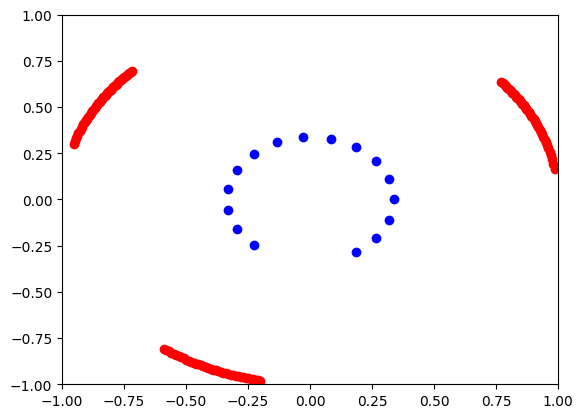

In [119]:
import math

# nb_transmitter = 30
# transmitter_positions = []
# for i in range(nb_transmitter):
#     x = random.random()*2 - 1
#     y = math.sqrt(1 - x**2)
#     if(random.choice([True, False])):
#         y = 0-y
#     transmitter_positions.append([x,y])

# transmitter_positions = np.array(transmitter_positions)

# samples = [[ 0.77096464  0.63687795], [-0.59013082 -0.80730763], [-0.9539165   0.30007217] ]

transmitter_positions = []

x = 0.77096464
for i in range(44):
    xi = x+0.005*i
    yi = math.sqrt(1 - xi**2)
    transmitter_positions.append([xi, yi])

x = -0.59013082
for i in range(40):
    xi = x+0.01*i
    yi = math.sqrt(1 - xi**2)
    transmitter_positions.append([xi, 0-yi])

x = -0.9539165
for i in range(48):
    xi = x+0.005*i
    yi = math.sqrt(1 - xi**2)
    transmitter_positions.append([xi, yi])

transmitter_positions = np.array(transmitter_positions)

antenna_positions = np.array([[ 0.33684546,  0.        ],
       [ 0.31859424,  0.10937354],
       [ 0.2658184 ,  0.20689476],
       [ 0.184237  ,  0.28199573],
       [ 0.08269067,  0.32653808],
       [-0.02781648,  0.33569496],
       [-0.13530928,  0.30847409],
       [-0.22813922,  0.24782526],
       [-0.29624674,  0.16032072],
       [-0.33225133,  0.05544294],
       [-0.33225133, -0.05544294],
       [-0.29624674, -0.16032072],
       [-0.22813922, -0.24782508],
       [ 0.184237  , -0.28199573],
       [ 0.2658184 , -0.20689476],
       [ 0.31859424, -0.10937354]])

plt.xlim([-1,1])
plt.ylim([-1,1])
plt.plot(antenna_positions[:,0],
         antenna_positions[:,1],
         'bo',
         transmitter_positions[:,0],
         transmitter_positions[:,1],
         'ro'
         )
plt.show()


**Matched beamforming**

In [120]:
def generate_covariance_matrix(
        antenna_positions,
        user_positions,
        user_intensities=None,
        additional_degrees_of_freedom=0,
        noise_level=0.1
):
    if user_intensities is None:
        user_intensities = np.ones(len(user_positions))

    steering_matrix = np.exp(-2 * np.pi * 1j * (antenna_positions @ user_positions.T))
    res = steering_matrix @ np.diag(user_intensities) @ np.conj(steering_matrix).T

    return res + noise_level * sp.stats.wishart.rvs(
        df=len(res) + additional_degrees_of_freedom,
        scale=np.eye(len(res)),
        size=1
    )

[ 14.85  35.4   58.95  83.25 108.   133.05 159.45 187.95 214.65 239.4
 264.45 290.1 ]


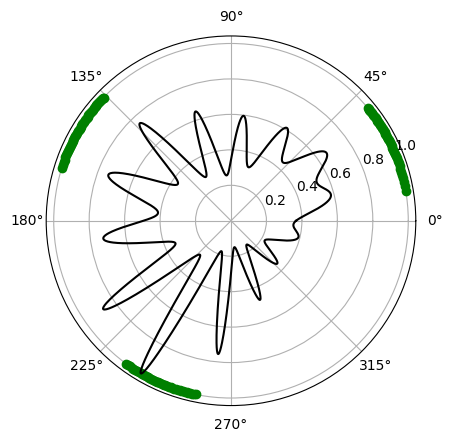

In [121]:
def cartesian_to_arg(cartesian_coords):
    return np.angle(cartesian_coords[0] + cartesian_coords[1] * 1j)

resolution = 0.15
time_t = 0

cov = generate_covariance_matrix(antenna_positions, transmitter_positions, noise_level=0)

doas, widths, _, psd, thetas = music_algorithm(cov, antenna_positions, wavelength, 13, resolution=resolution)
thetas *= np.pi/180

print(doas)

plt.polar(list(map(cartesian_to_arg,transmitter_positions)), np.ones(len(transmitter_positions)), "go", thetas, psd/np.max(psd), '-k')
plt.show()

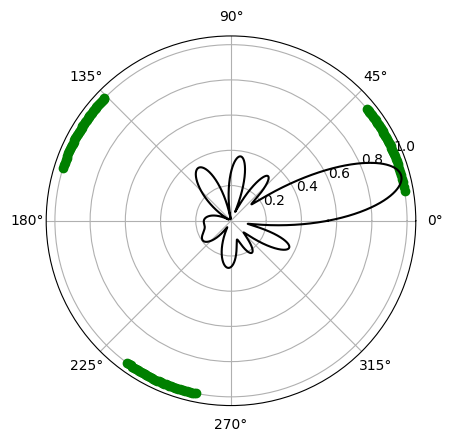

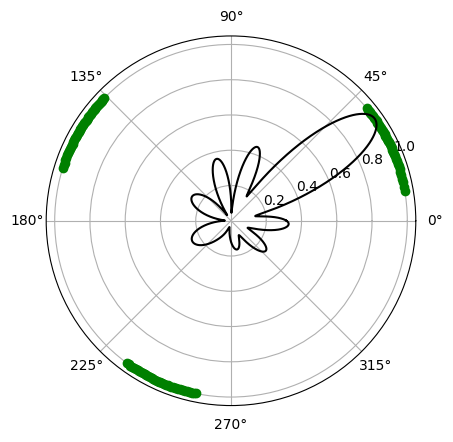

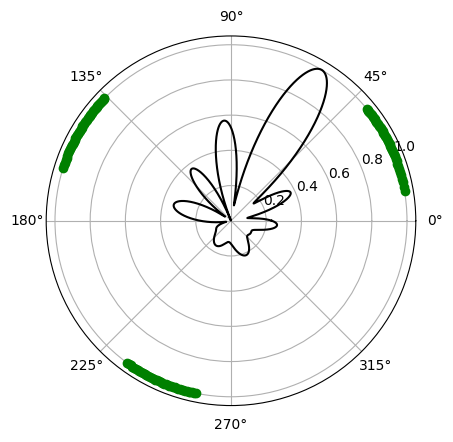

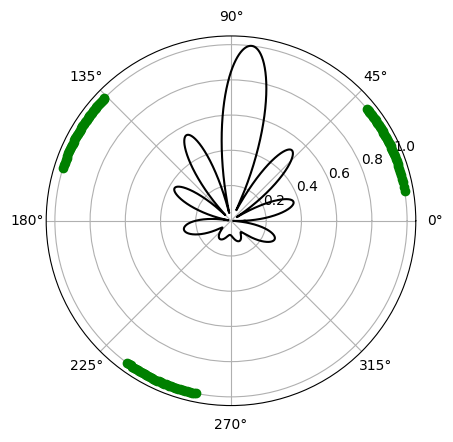

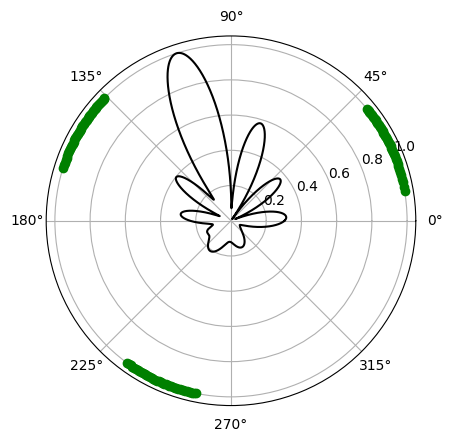

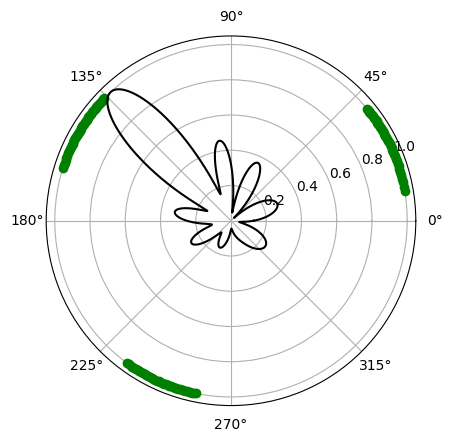

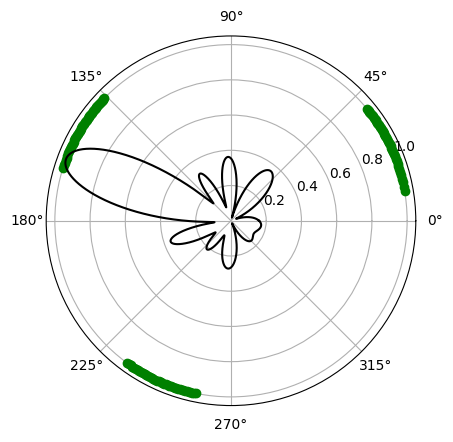

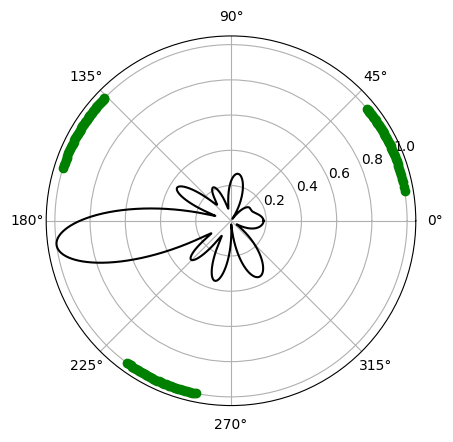

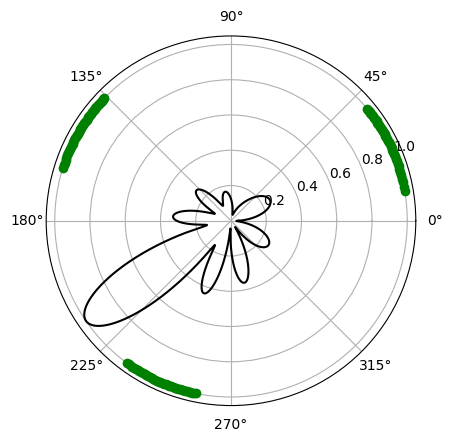

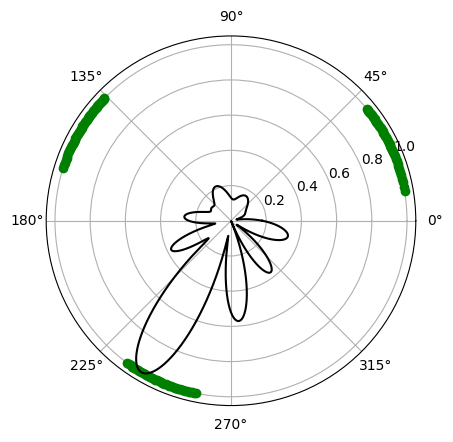

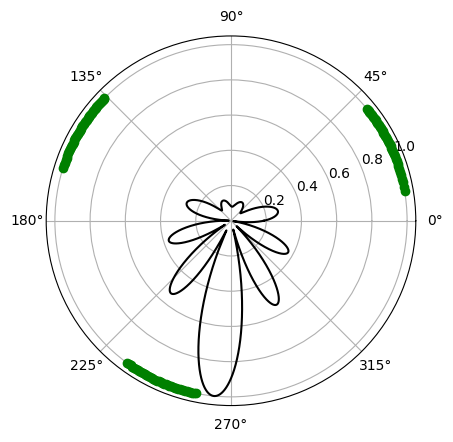

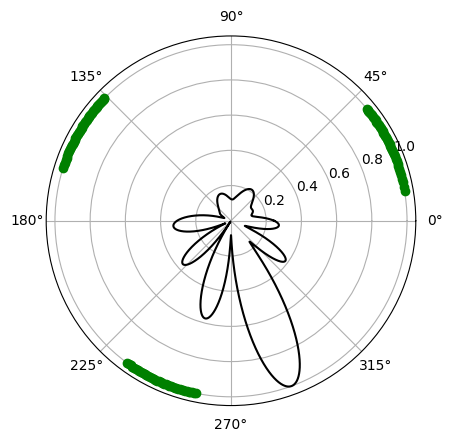

In [117]:
for d in doas:
    angle = d * np.pi/180
    r0 = np.array([np.cos(angle), np.sin(angle)])
    b_gains, ts = matched_beam(antenna_positions, wavelength, r0)
    plt.polar(list(map(cartesian_to_arg,transmitter_positions)), np.ones(len(transmitter_positions)), "go", ts, b_gains/np.max(b_gains), '-k')
    plt.show()

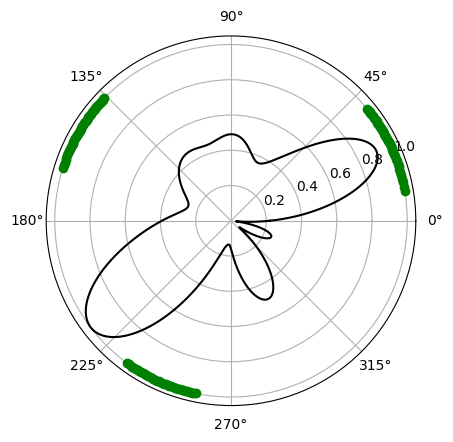

In [118]:
b_gains, ts = flexibeam(antenna_positions, doas, widths, wavelength)

plt.polar(list(map(cartesian_to_arg,transmitter_positions)), np.ones(len(transmitter_positions)), "go", ts, b_gains/np.max(b_gains), '-k')
plt.show()